# Week 4 COVID-19 Prediction with Interpret_ML
This notebook will describe attempt at predicting the amount of Confirmed and Fatalities for the 3rd week of the COVID-19 Kaggle Competition, using models created from the [Interpret_ML toolbox](https://github.com/interpretml/interpret)

## Data Sources & Collection
We're using data that was collected or scraped from various sources, some of which are courtesy of work already done by other people that will be credited. Other data that we're presenting (and will be appending to the training data) are collected from multiple other sources, using some tools as can be seen in the Github page [here](). The list of sources as well as the sources that we'll be featuring in this notebook are listed here, namely:

1. [Worldometer Coronavirus page](https://www.worldometers.info/coronavirus/), which we believe contains the most updated information on the number of Confirmed and Fatalities that happen globally. As of 5 April, noted to have been updated to contain the latest amount of tests that happen globally, however noted that no time series for all countries are provided yet (in Worldometer itself).
2. Global climate Data from [Worldbank](https://datahelpdesk.worldbank.org/knowledgebase/articles/902061-climate-data-api). As explained a bit later in the notebook, we believe that a country's current climate condition might have a bit of effect on the spread of the virus.
3. [Our World in Data](https://ourworldindata.org/covid-testing), who has provided quite an updated time series for the recorded tests conducted by many countries for COVID-19. It is to be noted however, due to not all countries having released test data, only several countries could have their data imputed (and not by region)
4. [The COVID Tracking Project](https://covidtracking.com/ ), to specifically provide data COVID-19 testing that has so far been recorded in the US. It is noted and understood that this will only be helping mainly to predict the outcome in US and its region

## Short Introduction to InterpretML
[InterpretML](https://github.com/interpretml/interpret) is a Machine Learning toolbox developed by Microsoft Research, with the goal of giving better interpretability to trained Machine Learning models. For COVID-19 forecasting in particular, we believe that this toolbox will provide better understanding of the correlation between many different features and the model's prediction, hopefully helping in answering some of the [scientific questions](https://www.kaggle.com/c/covid19-global-forecasting-week-4/overview/open-scientific-questions) regardng the factors which effect COVID-19 transmission.

[TODO: summarize what InterpretML is, and provide some of the model examples that can be used from the InterpretML toolbox]

For this notebook, we'll create several models from the [InterpretML toolbox library](https://github.com/interpretml/interpret). These models will be trained using different sets of features (including the default features provided), which will then have their performances be compared to each other.  

## Loading of Interpret_ML.
First ensure that the Interpret_ML toolbox is installed with pip   

In [ ]:
!pip install -U interpret

In [1]:
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

import datetime
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import copy

## 1. Appending of the the Training Dataset with other Features
Now that Interpret_ML has been installed, let's first review and take note of the training and test data that has been provided by default, to see what features could be extracted for use later.

In [2]:
import pandas as pd 
import numpy as np 

train_default_path = "../input/train.csv"
test_default_path = "../input/test.csv"

train_default_data = pd.read_csv(train_default_path)
#train_default_data

In [3]:
test_default_data = pd.read_csv(test_default_path)
#test_default_data

From looking at these data, it can be seen that the number of previously known number of Confirmed and Fatalities would be the main default features that could be extracted and used. Based on expert opinions as well as various other works however, it seems that these features would not be sufficient in accurately predicting the total amount of Confirmed and Fatalities in the future.

Hence, additional data features would be required. In this notebook, several of the additional data features that we've collected can be seen below:

### 1.a. Weather features
Thanks to the work by David Bonin (Kaggle user [davidbn92](https://www.kaggle.com/davidbnn92)) in his [notebook](https://www.kaggle.com/davidbnn92/weather-data/output), a variation of the training data that has been appended with Weather/climate features of all regions has been provided. As noted in their page, these weather data are courtesy of [NOAA GSOD readings](https://www.kaggle.com/noaa/gsod), which has been appended to the training data.

In [4]:
train_appended_df = pd.read_csv("../input/training_data_with_weather_info_week_4.csv")
print("Current columns:", train_appended_df.columns)
#train_appended_df

Current columns: Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities', 'country+province', 'Lat', 'Long', 'day_from_jan_first',
       'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp',
       'fog'],
      dtype='object')


In [5]:
training_data_unique_regions = train_appended_df['Province_State'].unique()
#training_data_unique_regions, len(training_data_unique_regions)

As per noted by David in his work, the weather features that were added included the following:

- ```temp```: Mean temperature for the day in degrees Fahrenheit to tenths.
- ```max```: Maximum temperature reported during the day in Fahrenheit to tenths--time of max temp report varies by country and region, so this will sometimes not be the max for the calendar day.
- ```min```: Minimum temperature reported during the day in Fahrenheit to tenths--time of min temp report varies by country and region, so this will sometimes not be the min for the calendar day.
- ```stp```: Mean station pressure for the day in millibars to tenths.
- ```slp```: Mean sea level pressure for the day in millibars to tenths.
- ```dewp```: Mean dew point for the day in degrees Fahrenheit to tenths.
- ```wdsp```: Mean wind speed for the day in knots to tenths.
- ```prcp```: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation--i.e., may include latter part of previous day. .00 indicates no measurable precipitation (includes a trace).
- ```fog```: Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day

The reason to include weather data for COVID-19 prediction would is because of some previous research (example of such paper [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2916580/)) linking the coronavirus family having [seasonality period](https://www.bbc.com/future/article/20200323-coronavirus-will-hot-weather-kill-covid-19), with indication that warmer weather could [slow down](https://www.theguardian.com/world/2020/apr/05/scientists-ask-could-summer-heat-help-beat-covid-19) the transmission of the virus. However, similarly there has been caution by health experts that this might not be [true](https://www.sciencenews.org/article/coronavirus-warm-weather-will-not-slow-covid-19-transmission). 

As such, we'll investigate using the InterpretML toolbox to see the correlation between any of these weather effect with COVID-19 forecasting.

### 1.b. Population Data 
Specifically, the Population Density for each region. Hypothetically, a region that has a higher population density should in theory have a higher chance of faster COVID-19 transmission. For consistency, we'll be mainly using the countries' and regions' population and population density data that was recorded by [Worldometer](https://www.worldometers.info/world-population/population-by-country/) from their respective country pages. 


In [6]:
population_df = pd.read_csv("../input/Worldometer_Population_Regional_Latest.csv")
#population_df

In [7]:
#list the unique regions in the population_df DataFrame, while also removing the 'All_Regions' tag (which indicate it's the population of the whole country, and not just a region)
popdf_unique_regions = population_df['Region'].unique()
popdf_unique_regions = np.sort(popdf_unique_regions[popdf_unique_regions != 'All_Regions'])
print("All {} unique regions recorded:".format(str(len(popdf_unique_regions))))
print(popdf_unique_regions, "True Victoria" in popdf_unique_regions)

All 6789 unique regions recorded:
["'Afak" "'Ajlun" "'Ali Sabieh" ... '`Izra' 'eMbalenhle' 'maalot Tarshiha'] False


(Note that 'All_regions' mean that the data shown in that particular row applies to the whole country, not just a particular region in that country)

However, as can be seen it is noted that Worldometer doesn't seem to provide the Population Density features recorded for regional levels. Hence, for countries with regions in the training data, we'll instead use the countries' and regions' population data as of 2019 provided by OECD on their [Region and Cities](https://stats.oecd.org/Index.aspx?DataSetCode=REGION_DEMOGR#) page. It is noted that these would not likley reflect the lates population density for all region/provinces in the training data. However, we believe the difference in population density for these regions between 2019 and 2020 should be minimal enough such that the the difference should be rather minimal. A reliable source that could help with this would be helpful as an input/feedback.

Note that OECD divides the regions into 2 types: T2 (Large) and T3 (Small) Regions. Let's take a glimpse at the population density records for all region types in 2019 first.

In [8]:
population_density_area_df = pd.read_csv("../input/OECD_PopulationDensity_and_Area-T2_T3_Regions-2018_2019.csv")
print("Columns available:", population_density_area_df.columns)
population_density_area_df.head()

Columns available: Index(['TL', 'Territory Level and Typology', 'REG_ID', 'Region', 'VAR',
       'Indicator', 'SEX', 'Gender', 'POS', 'Position', 'TIME', 'Year',
       'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode',
       'Reference Period Code', 'Reference Period', 'Value', 'Flag Codes',
       'Flags'],
      dtype='object')


,TL,Territory Level and Typology,REG_ID,Region,VAR,Indicator,SEX,Gender,POS,Position,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,1,Country,AUT,Austria,POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2018,RATIO,Ratio,0,Units,NaN,NaN,106.91,NaN,NaN
1,2,Large regions (TL2),AT21,Carinthia,POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2018,RATIO,Ratio,0,Units,NaN,NaN,59.88,NaN,NaN
2,1,Country,BEL,Belgium,SURF,Regional surface,T,Total,ALL,All regions,...,2018,KM2,Square kilometres,0,Units,NaN,NaN,30451.00,NaN,NaN
3,2,Large regions (TL2),BE1,Brussels Capital Region,POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2018,RATIO,Ratio,0,Units,NaN,NaN,7441.31,NaN,NaN
4,2,Large regions (TL2),DED,Saxony,POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2018,RATIO,Ratio,0,Units,NaN,NaN,224.54,NaN,NaN


In [9]:
#Limit to only population density data, and in Year 2019 only
population_density_only = population_density_area_df[population_density_area_df["VAR"] == "POP_DEN"]
population_density_only.drop(['SEX', 'Gender', 'POS', 'Position', 'PowerCode Code', 'Reference Period Code', 'Reference Period'], axis=1)
population_density_2019 = population_density_only[population_density_only["Year"] == 2019]
population_density_unique_regions = population_density_2019['Region'].unique()
print("All unique {} regions recorded for OECD's population density data: ".format(str(len(population_density_unique_regions))), 
                                                                                    population_density_unique_regions)
population_density_2019.head()

All unique 2938 regions recorded for OECD's population density data:  ['Guerrero, R4' 'Jalisco' 'Mexico, R2' ... 'Altai Krai' 'Sud-Ouest'
 'Chelyabinsk Oblast']


,TL,Territory Level and Typology,REG_ID,Region,VAR,Indicator,SEX,Gender,POS,Position,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
1099,3,Small regions (TL3),ME12R4,"Guerrero, R4",POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2019,RATIO,Ratio,0,Units,NaN,NaN,52.31,NaN,NaN
1103,2,Large regions (TL2),ME14,Jalisco,POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2019,RATIO,Ratio,0,Units,NaN,NaN,105.33,NaN,NaN
1105,3,Small regions (TL3),ME15R2,"Mexico, R2",POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2019,RATIO,Ratio,0,Units,NaN,NaN,1877.13,NaN,NaN
1121,3,Small regions (TL3),ME17R5,"Morelos, R5",POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2019,RATIO,Ratio,0,Units,NaN,NaN,142.19,NaN,NaN
1135,3,Small regions (TL3),ME19R3,"Nuevo Leon, R3",POP_DEN,Population density (pop. per km2),T,Total,ALL,All regions,...,2019,RATIO,Ratio,0,Units,NaN,NaN,2.95,NaN,NaN


Adding these population data into the modified training_data:

In [10]:
#train_appended_df = train_appended_df.copy()
#Initiate new feature columns
added_features = ['Population (2020)', 'Population Density']
for feature in added_features:
    train_appended_df[feature] = 0

for country in train_appended_df['Country_Region'].unique():
    #print(train_appended_df['Population (2020)'].unique())
    country_segment = train_appended_df[train_appended_df['Country_Region'] == country]

    #Sanity check for several countries, as they're apparently named quite differently in Worldometers vs the training data
    if country == "Burma":
        country = "Myanmar" #Burma in Training data is actually Myanmar. History stuff I guess?
    elif country == "Korea, South":
        country = "South Korea" #this one is honestly just trolling at this point...

    population_df_country = population_df[population_df['Country (or dependency)'] == country]#['Region'] == 'All_Regions'

    #check whehter the current country has any listed states/regions in the original training data.
    #If yes: Add regional population and regional population density data
    #If not: Only add country population and population density data.
    country_regions_training = list(country_segment['Province_State'].unique())

    #Apparently there are 2 'Congo'-s: Republic of Congo/Brazzaville, vs DEMOCRATIC Republic of Congo/Zaire (as how it's differentiated in Worldometers)
    if country == "Congo (Brazzaville)": 
        country = "Congo"
        country_regions_training = ["Brazzaville"]
    elif country == "Congo (Kinshasa)":
        country = "Congo"
        country_regions_training = ["Kinshasa"]

    if country_regions_training == [np.NaN]:
        #print(country, country_regions_training)
        
        #sanity check: in case country isn't listed in the worldometers population data, 
        #then query to the population_df would return DataFrame of 0
        if len(population_df_country) != 0:
            try:
                country_population = int(population_df_country[population_df_country['Region'] == "All_Regions"]["Population (2020)"].values[0].replace(",", "")) 
            except:
                print("Problematic country for pop. df", country, country_regions_training)
            try:
                country_population_density = population_df_country[population_df_country['Region'] == "All_Regions"]["Density (P/Km²)"].values[0]
            except:
                print("Problematic country for pop_density df", country, country_regions_training)
                break
        else:
            continue
            
        country_ids = country_segment.index.tolist()
        train_appended_df.loc[country_ids, ['Population (2020)']] = country_population
        train_appended_df.loc[country_ids, ['Population Density']] = country_population_density
    else:
        for region in country_regions_training:
            region_segment = country_segment[country_segment['Province_State'] == region]

            #sanity check, as apparently the region names are not truly unique to a country in Worldometer's data
            #(in particular, the region 'Victoria' which is unique to Australia in training data, is not present in Worldometer's Australia,
            # and instead available for other countries.)
            region_popdf_segment = population_df_country[population_df_country['Region'] == region]
            region_popdensity_segment = population_density_2019[population_density_2019['Region'] == region]

            if len(region_popdf_segment) == 1: #Means that there is a valid row available in Worldometer's population_data
                region_population = int(region_popdf_segment["Population (2020)"].values[0].replace(",", "") )
                #region_population = int(population_df_country[population_df_country['Region'] == region]["Population (2020)"].values[0].replace(",", ""))
            else:
                region_population = np.NaN

            if len(region_popdensity_segment) == 1:
                region_population_density = population_density_2019[population_density_2019['Region'] == region]['Value'].values[0]
            else:
                region_population_density = np.NaN

            region_ids = region_segment.index.tolist()
            train_appended_df.loc[region_ids, ['Population (2020)']] = region_population
            train_appended_df.loc[region_ids,['Population Density']] = region_population_density
train_appended_df.head()
#print("Done")

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country+province,Lat,Long,day_from_jan_first,...,stp,slp,dewp,rh,ah,wdsp,prcp,fog,Population (2020),Population Density
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,Afghanistan-,33.0,65.0,22,...,999.9,1024.3,27.4,0.545709,0.186448,9.4,0.00,0,38928346.0,60
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,Afghanistan-,33.0,65.0,23,...,999.9,1020.8,22.8,0.461259,0.163225,14.9,99.99,1,38928346.0,60
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,Afghanistan-,33.0,65.0,24,...,999.9,1018.6,34.5,0.801794,0.325375,10.4,0.17,1,38928346.0,60
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,Afghanistan-,33.0,65.0,25,...,999.9,1018.0,37.8,0.728175,0.214562,6.1,0.57,1,38928346.0,60
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,Afghanistan-,33.0,65.0,26,...,999.9,1014.8,33.2,0.685513,0.231656,10.8,0.00,1,38928346.0,60


### Deal with missing values

There are some missing values in some of the appended features. <br> Since interpretml doesn't support missing features, we need to fill these missing values when we can. <br>

Weather:
* Fill in max, min with temp
* Too many missing values for slp,dewp,rh,ah, so we won't use it

Population: 
* Population (2020): <br>
Missing values caused because we don't have specific population for country+province, hence we will use data of country

In [11]:
feature_dummy = "max"
missing_index = np.where(train_appended_df[feature_dummy].isnull())[0]
train_appended_df.at[missing_index,feature_dummy] = train_appended_df["temp"][missing_index]

feature_dummy = "min"
missing_index = np.where(train_appended_df[feature_dummy].isnull())[0]
train_appended_df.at[missing_index,feature_dummy] = train_appended_df["temp"][missing_index]

"""
feature_dummy = "Population Density"
missing_index = np.where(train_appended_df[feature_dummy].isnull())[0]
missing_country_province = train_appended_df["country+province"][missing_index].unique()
for reg in missing_country_province:
    mask_ = train_appended_df["country+province"] == reg
    mask_ix_ = np.where(mask_)[0]
    mask_country_ = train_appended_df["country+province"] == reg.split('')
    if(len(np.where())):
        replacement = 
    else:
        print("No replacement found for {}".format(reg))
    train_appended_df[feature_dummy].at[mask_ix_,feature_dummy] = 
"""
#np.where(train_appended_df["country+province"] =="Australia")

#feature_dummy = "Population (2020)"

'\nfeature_dummy = "Population Density"\nmissing_index = np.where(train_appended_df[feature_dummy].isnull())[0]\nmissing_country_province = train_appended_df["country+province"][missing_index].unique()\nfor reg in missing_country_province:\n    mask_ = train_appended_df["country+province"] == reg\n    mask_ix_ = np.where(mask_)[0]\n    mask_country_ = train_appended_df["country+province"] == reg.split(\'\')\n    if(len(np.where())):\n        replacement = \n    else:\n        print("No replacement found for {}".format(reg))\n    train_appended_df[feature_dummy].at[mask_ix_,feature_dummy] = \n'

## Prepare features and observe which feature is significant

First we prepare the features. Note that we also add 'previous confirmed cases' and 'previous fatalities' as additional features. <br>

Then we can observe which feature is significant by looking at the pearson correlation and data visualization using the built in function provided by interpretml.

In [13]:
def preprocess(df,
               features = ['Days','Region',"prev_ConfirmedCases","prev_Fatalities"],
               targets = ["ConfirmedCases", "Fatalities"]):

    # Create category called Region: country_province
    region_list = ["{}_{}".format(df["Country_Region"][i], df["Province_State"][i]) for i in range(df.shape[0])]
    df["Region"]=region_list

    # Get first day of corona virus for each region
    unique_region_list = list(set(region_list))
    unique_region_list.sort()
    first_date_dict = {}
    for region in unique_region_list:
        mask = df["Region"]==region
        first_ix = np.where(df[mask]["ConfirmedCases"]>0)[0][0] -1    
        first_date = df[mask]["Date"].iloc[first_ix]
        first_date_dict[region] = first_date

    # add column "Days": number of days since the first day of case per each region
    def get_days(dt):
        return dt.days
    dummy = [first_date_dict[region] for region in df["Region"]]
    df["Days"]=(pd.to_datetime(df['Date'])-pd.to_datetime(dummy)).apply(get_days)

    # Add previous confirmed cases and previous fatalities to df
    loc_group=["Region"]
    for target in targets:
        df["prev_{}".format(target)] = df.groupby(loc_group)[target].shift()
        df["prev_{}".format(target)].fillna(0, inplace=True)
    
    for target in targets:
        df[target] = np.log1p(df[target])
        df["prev_{}".format(target)] = np.log1p(df["prev_{}".format(target)])
    
    X = df[features]
    Y = df[targets]
    
    return X,Y

In [14]:
features = ['Region',"prev_ConfirmedCases","prev_Fatalities",
            'Days',"day_from_jan_first",
            "temp","max","min","prcp","stp","prcp","fog","wdsp", # weather
            "Lat","Long"]
X,Y = preprocess(train_appended_df,features=features)

In [15]:
marginal = Marginal().explain_data(X, Y["ConfirmedCases"],"ConfirmedCases")
show(marginal)

<!-- http://127.0.0.1:7915/139875014890944/ -->

Observing the data above, we can conclude that the weather data is not significant.

## Train and Predict with Explainable Boosting Machine (EBM)

We will not use all the features we test above. But we use only "important" features

In [16]:
important_features = ['Region',"prev_ConfirmedCases","prev_Fatalities",
                        'Days',
                        "Lat","Long"]
X = X[important_features]

To have a prediction of the accuracy of our prediction model, we split the original data into train and validation. We train our model using the train data. Then we make prediction on the validation data and report our validation error. <br>

For the actual prediction on the test data, we train our model using the whole data (before splitting).

In [17]:
def split_train_val(X,Y, unique_region_list,num_of_val_days):
    
    train_ix = []
    val_ix = []
    for region in unique_region_list:
        
        mask = X["Region"]==region
        ix = np.where(mask)[0]
        
        train_ix += list(ix[:-num_of_val_days].flatten())
        val_ix += list(ix[-num_of_val_days:].flatten())
        
    return X.iloc[train_ix],X.iloc[val_ix],Y.iloc[train_ix],Y.iloc[val_ix]    

# IMPORTANT NOTE: We can only use prev_ConfirmedCases for the first day to predict

In [18]:
# IMPORTANT NOTE: assuming that X_features is sorted by number of days "Days"
ENFORCE_CONSTRAINT = True
seed = 1
def evaluate_rmse(Y_predicted,Y_true):
    """
    Y_predicted: n-by-d n is the number of data points, d is the number of criteria
    Y_true: n-by-d
    OUTPUT
    d elements
    """
    return np.sqrt(mean_squared_error(Y_predicted,Y_true,multioutput='raw_values'))

def predict(X_features,Y,num_validation_days,num_days_to_predict):
    unique_region_list = list(set(X_features["Region"]))
    unique_region_list.sort()
    print("No of unique region list: {}".format(len(unique_region_list)))
    
    ##################################################################
    # Train and Validation
    ##################################################################
    # Split to train and validation
    X_train,X_val,Y_train,Y_val = split_train_val(X,Y, unique_region_list,num_validation_days)
    
    # Train
    model_ConfirmedCases = ExplainableBoostingRegressor(random_state=seed)
    model_ConfirmedCases.fit(X_train,Y_train["ConfirmedCases"])
    model_Fatalities = ExplainableBoostingRegressor(random_state=seed)
    model_Fatalities.fit(X_train,Y_train["Fatalities"])
    
    # Predict for val
    Y_val_predicted = np.zeros((X_val.shape[0],2))
    
    for i in range(X_val.shape[0]):
        
        if(i==0 or X_val.iloc[i-1]["Region"] != X_val.iloc[i]["Region"]):
            pred_ConfirmedCases = model_ConfirmedCases.predict(X_val.iloc[[i]])[0]
            pred_Fatalities = model_Fatalities.predict(X_val.iloc[[i]])[0]
            
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_val.iloc[[i]]["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = 1.*X_val.iloc[[i]]["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_val.iloc[[i]]["prev_Fatalities"].item()):
                    pred_Fatalities = X_val.iloc[[i]]["prev_Fatalities"].item()
                    
        else:
            X_dummy  = X_val.iloc[[i]].copy(deep=True)
            X_dummy["prev_ConfirmedCases"] = pred_ConfirmedCases
            X_dummy["prev_Fatalities"] = pred_Fatalities
            pred_ConfirmedCases = model_ConfirmedCases.predict(X_dummy)
            pred_Fatalities =model_Fatalities.predict(X_dummy)
        
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = 1.* X_dummy["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                    pred_Fatalities = X_dummy["prev_Fatalities"].item()
                    
        Y_val_predicted[i,0] = pred_ConfirmedCases
        Y_val_predicted[i,1] = pred_Fatalities
        
    # Report validation accuracy
    val_rmse = evaluate_rmse(Y_val,Y_val_predicted)
    
    ##################################################################
    # Train w Full Model and Predict for Test
    ##################################################################
    # Train with full data
    model_full_ConfirmedCases = ExplainableBoostingRegressor(random_state=seed)
    model_full_ConfirmedCases.fit(X_features,Y["ConfirmedCases"])
    model_full_Fatalities = ExplainableBoostingRegressor(random_state=seed)
    model_full_Fatalities.fit(X_features,Y["Fatalities"])
    
    # Predict for test
    Y_test_predicted = np.zeros((len(unique_region_list)*num_days_to_predict,2))
    count=0
    for region in unique_region_list:
        mask = X_features["Region"]==region
        
        prev_ConfirmedCase_ = Y[mask]["ConfirmedCases"].iloc[-1]
        prev_Fatality_ = Y[mask]["Fatalities"].iloc[-1]
        
        #print(prev_ConfirmedCase_,np.exp(prev_ConfirmedCase_)-1, prev_Fatality_, np.exp(prev_Fatality_)-1)
        
        X_dummy = X[mask].iloc[[-1]].copy(deep=True)
        X_dummy["prev_ConfirmedCases"] = prev_ConfirmedCase_
        X_dummy["prev_Fatalities"] = prev_Fatality_
        X_dummy["Days"] = X_dummy["Days"]+1
        
        pred_ConfirmedCases = model_full_ConfirmedCases.predict(X_dummy)
        pred_Fatalities = model_full_Fatalities.predict(X_dummy)
        
        if(ENFORCE_CONSTRAINT):
            if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                pred_ConfirmedCases = X_dummy["prev_ConfirmedCases"].item()
            if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                pred_Fatalities = X_dummy["prev_Fatalities"].item()
                
        Y_test_predicted[count,0] = pred_ConfirmedCases
        Y_test_predicted[count,1] = pred_Fatalities
        count = count+1
        
        for days_ahead in range(2,num_days_to_predict+1):
            
            X_dummy["prev_ConfirmedCases"] = pred_ConfirmedCases
            X_dummy["prev_Fatalities"] = pred_Fatalities
            X_dummy["Days"] = X_dummy["Days"]+1
            pred_ConfirmedCases = model_full_ConfirmedCases.predict(X_dummy)
            pred_Fatalities = model_full_Fatalities.predict(X_dummy)
            
            if(ENFORCE_CONSTRAINT):
                if(pred_ConfirmedCases<X_dummy["prev_ConfirmedCases"].item()):
                    pred_ConfirmedCases = X_dummy["prev_ConfirmedCases"].item()
                if(pred_Fatalities<X_dummy["prev_Fatalities"].item()):
                    pred_Fatalities = X_dummy["prev_Fatalities"].item()
                
            Y_test_predicted[count,0] = pred_ConfirmedCases
            Y_test_predicted[count,1] = pred_Fatalities
            
            count = count+1
      
    assert count==len(Y_test_predicted), "Something wrong"
    

    return unique_region_list,X_val,Y_val,Y_val_predicted,val_rmse,Y_test_predicted

In [19]:
num_days_to_predict = 43
num_validation_days = 10
unique_region_list,X_val,Y_val,Y_val_predicted,val_rmse,Y_test_predicted=predict(X,Y,num_validation_days,num_days_to_predict)

No of unique region list: 313


In [20]:
# Validation error
print("RMSE for ConfirmedCases and Fatalities: {}".format(val_rmse))

RMSE for ConfirmedCases and Fatalities: [0.64018532 0.46385296]


In [21]:
# This is the final value ConfirmedCases and Fatalities
# Convert back to linear scale
Y_test_predicted_final = np.exp(Y_test_predicted)-1
Y_val_predicted_final = np.exp(Y_val_predicted)-1

## Result Visualization

We visualize the result of our model here by plotting the actual data, our validation prediction, and the test prediction.

In [23]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [24]:
# Choose using region_ix
#region_ix = 3
#region = unique_region_list[region_ix]

# Choose using region
region = "Indonesia_nan"
region_ix = unique_region_list.index(region)

USE_LOG_SCALE=False
PLOT_LINE = False
##############################################

mask = X["Region"]==region
N = Y[mask].shape[0]
x_ = np.arange(N+num_days_to_predict)

validation_confirmed_cases = Y_val_predicted_final[region_ix*num_validation_days:(region_ix+1)*num_validation_days,0]
validation_fatalities = Y_val_predicted_final[region_ix*num_validation_days:(region_ix+1)*num_validation_days,1]
predicted_confirmed_cases = Y_test_predicted_final[region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,0]
predicted_fatalities = Y_test_predicted_final[region_ix*num_days_to_predict:(region_ix+1)*num_days_to_predict,1]

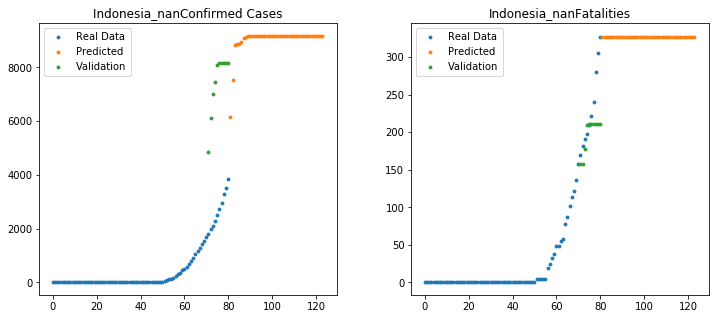

In [25]:
sz = 8
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.25)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
if(USE_LOG_SCALE):
    ax1.set_yscale('log')
    ax2.set_yscale('log')
ax1.scatter(x_[:N],np.exp(Y[mask]["ConfirmedCases"])-1, label="Real Data",s=sz)
ax1.scatter(x_[N:],predicted_confirmed_cases, label="Predicted",s=sz)
ax1.scatter(x_[N-num_validation_days:N],validation_confirmed_cases,label="Validation",s=sz)
if(PLOT_LINE):
    ax1.plot(x_[:N],np.exp(Y[mask]["ConfirmedCases"])-1, label="Real Data")
    ax1.plot(x_[N:],predicted_confirmed_cases, label="Predicted")
    ax1.plot(x_[N-num_validation_days:N],validation_confirmed_cases,label="Validation")
ax1.set_title(region+"Confirmed Cases")
ax1.legend()

ax2.scatter(x_[:N],np.exp(Y[mask]["Fatalities"])-1, label="Real Data",s=sz)
ax2.scatter(x_[N:],predicted_fatalities, label="Predicted",s=sz)
ax2.scatter(x_[N-num_validation_days:N],validation_fatalities,label="Validation",s=sz)
if(PLOT_LINE):
    ax2.plot(x_[:N],np.exp(Y[mask]["Fatalities"])-1, label="Real Data")
    ax2.plot(x_[N:],predicted_fatalities, label="Predicted")
    ax2.plot(x_[N-num_validation_days:N],validation_fatalities,label="Validation")

ax2.set_title(region+"Fatalities")
ax2.legend()